## <u>EJERCICIO 2</u>
### **CLASIFICACION CON Regresion logistica, KNN y SVM**

### PASO 0 - Importo las librerias y carga del dataset

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn import linear_model, neighbors, svm

In [2]:
# Utilizaremos solo imagenes de 7 personas con mas de 70 imagenes disponibles.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1, color=False, download_if_missing=True)

# Inspeccion de los tamaños
n_samples, h, w = lfw_people.images.shape

# Datos sin divir en subconjuntos
X = lfw_people.images

# Etiquetas y clases
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("h, w: (%d, %d)" % (h, w))
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)

Total dataset size:
h, w: (125, 94)
n_samples: 1288
n_classes: 7


In [3]:
print(target_names)
print(X.shape)
print(y.shape)
print(y[0])
print(X[0])

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
(1288, 125, 94)
(1288,)
5
[[0.99607843 0.99607843 0.9986928  ... 0.21699347 0.20261438 0.20653595]
 [0.99607843 0.9973857  0.99607843 ... 0.22222222 0.20261438 0.20653595]
 [0.9986928  0.9973857  0.99346405 ... 0.2248366  0.20522876 0.20522876]
 ...
 [0.3150327  0.29542485 0.2535948  ... 0.39346406 0.37908497 0.37124184]
 [0.29934642 0.2875817  0.2535948  ... 0.38562092 0.38300657 0.38300657]
 [0.27973858 0.27320263 0.25751635 ... 0.38431373 0.38039216 0.38039216]]


In [4]:
#Funciones para graficar
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

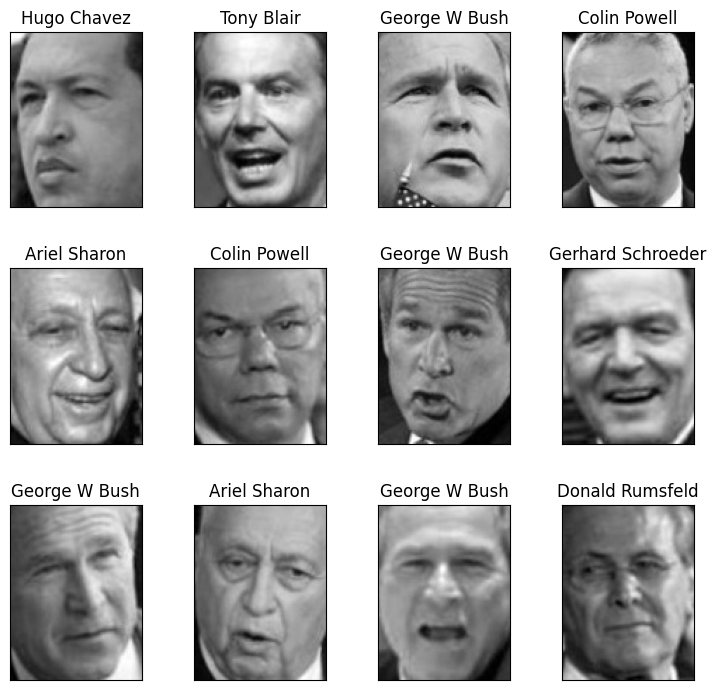

In [5]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(X, 12 , titles, h, w)

In [6]:
print(np.max(X))
print(np.min(X))

1.0
0.0


### PASO 1 - Reduccion de simensionalidad con PCA

In [7]:
# Convierto las imagenes a vectores en 1D

x_original = []
for i in range(len(X)):
    x_original.append(X[i].ravel())
x_original = np.array(x_original)

In [8]:
print(x_original.shape)
print(x_original)

(1288, 11750)
[[0.99607843 0.99607843 0.9986928  ... 0.38431373 0.38039216 0.38039216]
 [0.16470589 0.12941177 0.1267974  ... 0.47843137 0.5816994  0.7267974 ]
 [0.36862746 0.28235295 0.2901961  ... 0.7163399  0.7176471  0.71503276]
 ...
 [0.35424837 0.35686275 0.35555556 ... 0.19869281 0.16993465 0.14640523]
 [0.19869281 0.19869281 0.19346406 ... 0.6614379  0.61960787 0.4745098 ]
 [0.12287582 0.13071896 0.10457516 ... 0.18954249 0.24705882 0.3882353 ]]


In [9]:
# Aplico PCA para seleccionar los componentes principales

reduccion_pca = PCA(n_components=192)
x_transformada = reduccion_pca.fit_transform(x_original)

print(f"Data convertida a 1D: {x_original.shape}")
print(f"Data reducida: {x_transformada.shape}")

sumatoria = np.sum(reduccion_pca.explained_variance_ratio_)
print(f"Porcentaje de vararianza explicada: {sumatoria}")

Data convertida a 1D: (1288, 11750)
Data reducida: (1288, 192)
Porcentaje de vararianza explicada: 0.9421956539154053


### PASO 2 - Divido las data en entrenamiento y test

In [10]:
# Division de los datos normalizados

porc_test = 0.2
seed = 8

x_entrenar, x_test, y_entrenar, y_test = train_test_split(x_transformada, y, test_size=porc_test, random_state=seed, shuffle=True)


print(f"Entrenamiento: {x_entrenar.shape}")
print(f"Testeo: {x_test.shape}")

Entrenamiento: (1030, 192)
Testeo: (258, 192)


### PASO 2.5 - Creo una funcion para el entrenamiento y matriz de confusion para los distintos modelos

In [11]:
def modelo(clasificador, x_entrenar, y_entrenar, x_test, y_test, tipo_modelo):
    
    # Entrenamiento del modelo
    clasificador.fit(x_entrenar, y_entrenar)
    print("\nAccuracy")
    print(f"Precision con datos {clasificador.score(x_test, y_test)}")
    y_prediccion = clasificador.predict(x_test)
    
	# Matriz de confusion y grafica
    confm = confusion_matrix(y_test, y_prediccion)
    print(f"\nMatriz de confusion para {tipo_modelo}")
    print(confm)
    
    grafico = ConfusionMatrixDisplay.from_estimator(clasificador, x_test, y_test, cmap="YlGn")
    grafico.ax_.set_title(f"Grafico Matriz de confusion para {tipo_modelo}")
    grafico.ax_.set_xlabel("Etiquetas de prediccion")
    grafico.ax_.set_ylabel("Etiquetas de testeo")
    grafico.ax_.set_xticklabels(target_names)
    grafico.ax_.set_yticklabels(target_names)
    grafico.ax_.tick_params(axis="x", rotation=90)
    
	# Retorno el grafico de matriz de confusion
    return grafico

### PASO 3 - Modelo con Regresion Logistica


Accuracy
Precision con datos 0.8449612403100775

Matriz de confusion para Regresion Logistica
[[ 10   2   0   2   0   1   0]
 [  1  42   0   5   0   2   1]
 [  1   1  12   3   1   0   1]
 [  0   6   2 102   1   1   2]
 [  0   0   0   1  15   2   1]
 [  0   1   0   1   0  12   1]
 [  0   0   0   0   0   0  25]]


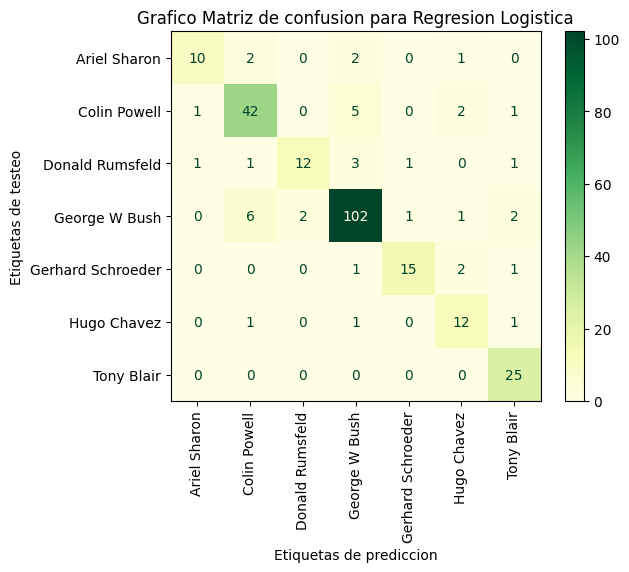

In [12]:
# Instancio el modelo de regresion logistica
regresion_logistica = linear_model.LogisticRegression(solver='lbfgs', C=100, max_iter=10000, random_state=24)

# LLamo a la funcion para calcular y graficar los datos tratados con PCA
modelo(regresion_logistica, x_entrenar, y_entrenar, x_test, y_test, "Regresion Logistica")

### PASO 4 - Modelo de clasificacion por vecinos cercanos - KNN


Accuracy
Precision con datos 0.6046511627906976

Matriz de confusion para KNN
[[ 3  9  2  1  0  0  0]
 [ 5 37  0  7  0  1  1]
 [ 0  5  7  6  0  0  1]
 [ 3 10  4 93  1  0  3]
 [ 0  4  2 10  1  0  2]
 [ 0  2  0  7  1  3  2]
 [ 0  1  0 10  2  0 12]]


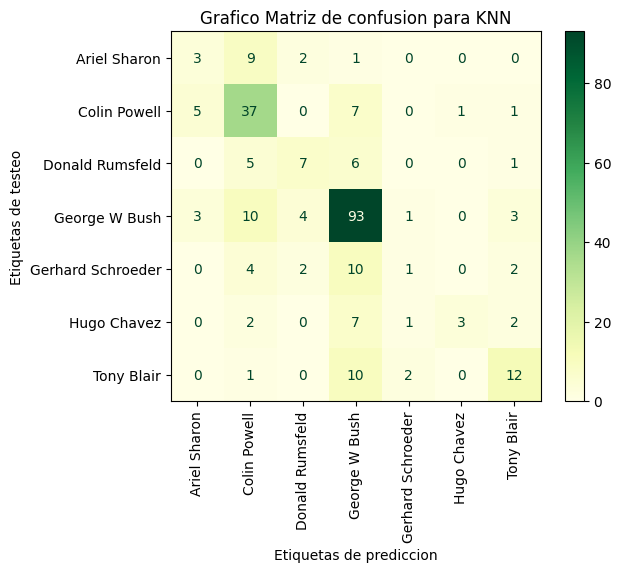

In [13]:
# Instancio el modelo de vecinos cercanos con el weight de distancia
clasf_knn = neighbors.KNeighborsClassifier(9, weights="distance")

# LLamo a la funcion para calcular y graficar los datos tratados con PCA
modelo(clasf_knn, x_entrenar, y_entrenar, x_test, y_test, "KNN")

### PASO 5 - Modelo de clasificacion por Maquina de Soporte Vectorial - SVM


Accuracy
Precision con datos 0.8682170542635659

Matriz de confusion para SVM
[[ 11   3   1   0   0   0   0]
 [  1  43   0   6   0   1   0]
 [  1   0  15   2   0   0   1]
 [  2   5   2 104   0   0   1]
 [  0   0   0   2  16   0   1]
 [  0   1   0   0   0  13   1]
 [  1   0   0   1   1   0  22]]


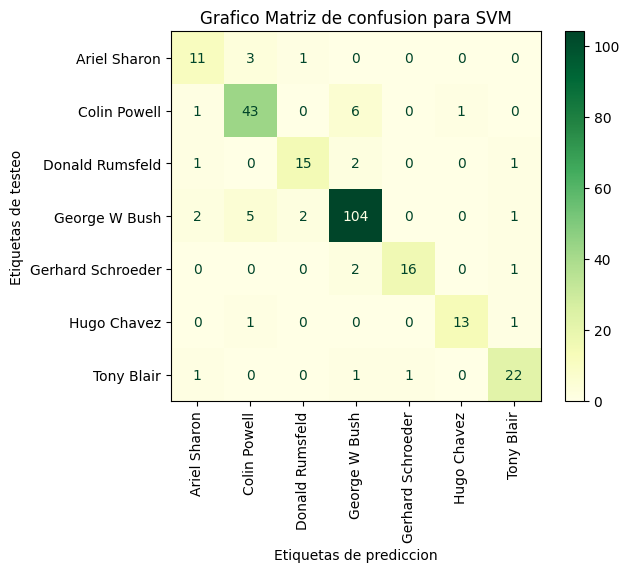

In [14]:
# Instancio el modelo de soporte de maquina vectorial
clasf_svm = svm.SVC(kernel="linear", C=1E7, random_state=24)

# LLamo a la funcion para calcular y graficar los datos tratados con PCA
modelo(clasf_svm, x_entrenar, y_entrenar, x_test, y_test, "SVM")

### PASO 6 - Conclusiones
**- Aplicacion del algoritmo PCA**
La adopcion de reducir las entradas a 192 componentes es porque busque una cantidad que formen una matriz de 12 x 16, la cual mantiene casi la misma proporcion que la original de 94 x 125. Luego al hacer la varianza explicada note que la perdida era de poco mas del 5%.

**- Clasificaciones**
A pesar de estar trabajando con los mismos conjuntos de datos, cada modelo tuvo un desempeño distinto. Si bien la reduccion de los datos de entrada fue de poco mas del 61%.
Se pudo lograr que la regresion logistica tenga una precision al rededor del 84% y en el modelo de SVM logro una precision al rededor del 87%, lo cual es bastante bueno y se puede decir que son modelos aptos para el trabajo con imagenes. Mientras que el desempeño del KNN es bastante inferior con respecto a los otros dos, se ve que la reduccion de los datos de entrada no le juega a favor en estas tareas. 
Cuando hice pruebas con cantidades de componentes que no guardaban una proporcion, como explicaba en el punto anterior, estas precisiones se veian bastante disminuidas a pesar de estar usando la misma semilla.  

(Aunque siempre use la misma semilla, a veces varian un poco los valores de precision en distintas ejecuciones)
